# This notebook will do the following:

* Queries metadata for all Chandra observations using HEASARC VO services.

* Extracts their sky coordinates.

* Plots them on an interactive all-sky map using matplotlib Aitoff projection.

# Dependencies

* astropy
* pyvo
* matplotlib

## Step 1: Imports

In [4]:
import pyvo as vo
import healpy
import os
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.heasarc import Heasarc
from astropy.table import Table
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
import numpy as np
%matplotlib inline
plt.style.use(astropy_mpl_style)

## Step 2: Use HEASARC VO Service to access Chandra observation metdata

You'll see options like:

* chandra_master (main Chandra observation metadata)

* chandra_images

* chandra_grating_obs

In [2]:
# HEASARC VO TAP service
heasarc = vo.dal.TAPService("https://heasarc.gsfc.nasa.gov/xamin/vo/tap")

## Step 3: Run a ADQL query to get all observation positions

In [3]:
query = """
SELECT TOP 99999999 obsid, ra, dec, exposure, detector, time, name
FROM chanmaster
WHERE ra IS NOT NULL AND dec IS NOT NULL
"""


results = heasarc.search(query)
table = results.to_table()
table[:5]

obsid,ra,dec,exposure,detector,time,name
,deg,deg,s,,d,
int32,float64,float64,float64,object,float64,object
21421,91.42333,-86.63194,23060,ACIS-S,58532.4990856481,ESO005-G004
10143,302.30417,-85.64633,2030,ACIS-S,54810.445474537,1RXSJ200924.1-853911
22326,49.31604,-85.54043,37930,ACIS-I,59201.2466550926,RE J0317-853
15124,354.93333,-85.17583,23080,ACIS-I,56636.0022569444,ACO 4023
3477,242.76000,-83.70000,20060,ACIS-S,52364.0807638889,GRB020321


## Step 4: Convert coordinates to SkyCoord and optionally galactic coords

In [4]:
coords = SkyCoord(ra=table['ra'],
                  dec=table['dec'])

## Step 5: Plot an all-sky map in Aitoff projection

/var/folders/sy/g6_2btr112l8xcgw6m5rh24rq4ql54/T/ipykernel_33315/323259755.py:4: RuntimeWarning: divide by zero encountered in log10
  exp_log = np.log10(table['exposure']/1000)
/Users/jeagle/miniforge3/envs/fermi/lib/python3.9/site-packages/numpy/lib/function_base.py:3639: RuntimeWarning: invalid value encountered in divide
  return sin(y)/y


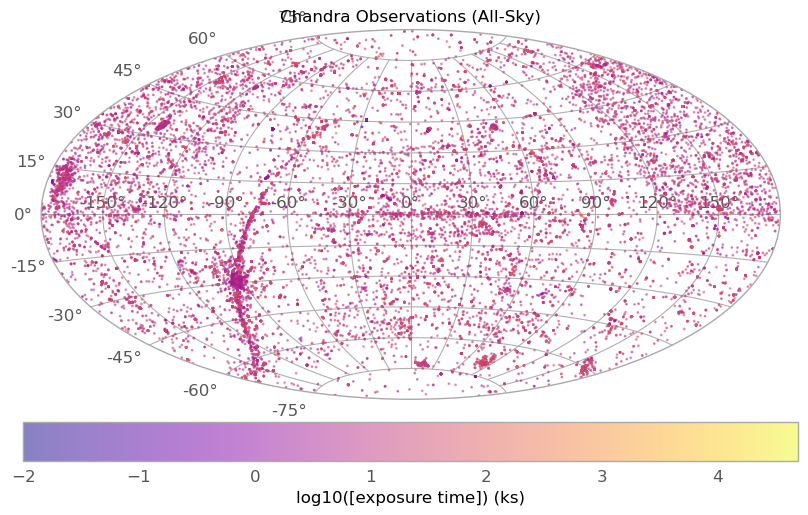

In [5]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="aitoff")

exp_log = np.log10(table['exposure']/1000)

# Convert RA to radians and flip for Aitoff
ra_rad = coords.ra.wrap_at(180*u.deg).radian
dec_rad = coords.dec.radian

sc = ax.scatter(ra_rad, dec_rad, c=exp_log,s=1, alpha=0.5, cmap='plasma')
cb = plt.colorbar(sc, orientation='horizontal', pad=0.05)
cb.set_label("log10([exposure time]) (ks)",fontsize=12)
ax.grid(True)
plt.title("Chandra Observations (All-Sky)",fontsize=12)
plt.show()

# Find Chandra source locations and fluxes for all-sky. 

## Find those that lie along the Galactic plane and plot the sky map.

In [6]:
columns = Heasarc.list_columns(catalog_name='csc')
columns.pprint(align='<',max_width=-1, max_lines=-1)

    name                                       description                                      unit   
------------ ------------------------------------------------------------------------------- ----------
significance Highest Source Signal-to-Noise Ratio Across All Stacked Obs. and Energy Bands             
dec          Declination                                                                     degree    
m_flux_ap_lo Net Energy Flux from Source Region Aperture (68% Lower Limit); ACIS Medium Band erg/s/cm^2
name         Source Designation (2CXO JHHMMSS.SsDDMMSS[X])                                             
m_flux_ap_hi Net Energy Flux from Source Region Aperture (68% Upper Limit); ACIS Medium Band erg/s/cm^2
b_flux_ap_hi Net Energy Flux from Source Region Aperture (68% Upper Limit); ACIS Broad Band  erg/s/cm^2
m_flux_ap    Net Energy Flux from Source Region Aperture, Bayesian Analysis; ACIS Medium     erg/s/cm^2
b_flux_ap_lo Net Energy Flux from Source Region Aperture (68% Lo

In [1]:
from astroquery.heasarc import Heasarc
# get a comma-separated list of the default columns in csc. Use columns = '*', to get all columns
columns = ', '.join(Heasarc._get_default_columns('csc'))
# construct a query for all entries; use TOP with a large number greater than the server's 1e5 LIMIT
query = f'SELECT TOP 9999999 {columns} FROM csc'
sample = Heasarc.query_tap(query).to_table()

In [2]:
print(sample)

         name             ra        dec     ... m_flux_ap_hi m_flux_ap_lo
                         deg        deg     ...  erg/s/cm^2   erg/s/cm^2 
--------------------- ---------- ---------- ... ------------ ------------
2CXO J000000.0+004331 359.999948   0.725261 ...      2.2e-15      1.1e-15
2CXO J000000.1+623124   0.000574  62.523404 ...      6.1e-16      1.1e-16
2CXO J000000.2-501250   0.000772 -50.214007 ...      6.1e-16      1.6e-16
2CXO J000000.3+321702   0.001488  32.284135 ...      3.3e-15      1.2e-15
2CXO J000000.5+321232   0.002214  32.209102 ...      1.6e-15      2.3e-16
2CXO J000000.5-575830   0.002735 -57.975181 ...      8.6e-15      5.5e-15
                  ...        ...        ... ...          ...          ...
2CXO J235959.1-501331 359.996564 -50.225460 ...      3.3e-15      2.3e-15
2CXO J235959.4-500934 359.997486 -50.159606 ...      7.7e-16      3.2e-16
2CXO J235959.4-573811 359.998168 -57.636382 ...      4.2e-14      3.5e-14
2CXO J235959.4-574903 359.998492 -57.8

In [7]:
query = """
SELECT TOP 9999999 name, ra, dec, b_flux_ap
FROM csc
WHERE b_flux_ap > 0
"""

sample = heasarc.search(query)
sample_table = sample.to_table()
sample_table[:5]

name,ra,dec,b_flux_ap
,deg,deg,erg/s/cm^2
object,float64,float64,float64
2CXO J000000.0+004331,359.999948,0.725261,3.6e-15
2CXO J000000.1+623124,0.000574,62.523404,7.1e-15
2CXO J000000.2-501250,0.000772,-50.214007,1.4e-15
2CXO J000000.3+321702,0.001488,32.284135,3.8e-15
2CXO J000000.5+321232,0.002214,32.209102,1.5e-14


In [8]:
print(len(sample_table))
print(f"{sample_table['b_flux_ap'].min():.2e}")
print(sample_table['b_flux_ap'].max())
print(np.sum(sample_table['b_flux_ap'])/len(sample_table))

343779
1.33e-18
1.3178257194102e-09
6.578420406143906e-14


In [9]:
#sample = heasarc.query_region(
#    SkyCoord(0, 0, unit='deg',frame='galactic'),
#    spatial='all-sky',
#    catalog='csc',
#    maxrec=None
#)
#fields parameter errors out every time.
#maxrec messes with the query, sending a random sample that matches the criteria for a maximum of 1e5 sources. 

#sample[:50]['name', 'ra', 'dec', 'b_flux_ap'].pprint(max_width=-1)

In [10]:
# Create SkyCoord from the sample table
coords = SkyCoord(ra=sample_table['ra'], dec=sample_table['dec'], unit='deg')
gal_coords = coords.galactic

# Apply Galactic latitude filter: |b| <= 10°
mask = np.abs(gal_coords.b.deg) <= 10

# Filter coordinates and data
filtered_coords = gal_coords[mask]
filtered_flux = sample_table['b_flux_ap'][mask]
filtered_names = sample_table['name'][mask]

print(f"Total sources in catalog: {len(coords)}")
print(f"Number of filtered sources: {len(filtered_coords)}")

Total sources in catalog: 343779
Number of filtered sources: 100896


In [11]:
print("Longitude range (unwrapped):", filtered_coords.l.min().deg, "to", filtered_coords.l.max().deg)
print("Longitude range (wrapped):", filtered_coords.l.wrap_at(180*u.deg).min().deg, "to", filtered_coords.l.wrap_at(180*u.deg).max().deg)

Longitude range (unwrapped): 7.268966595713397e-05 to 359.9999628317577
Longitude range (wrapped): -179.97416771920018 to 179.99153191582855


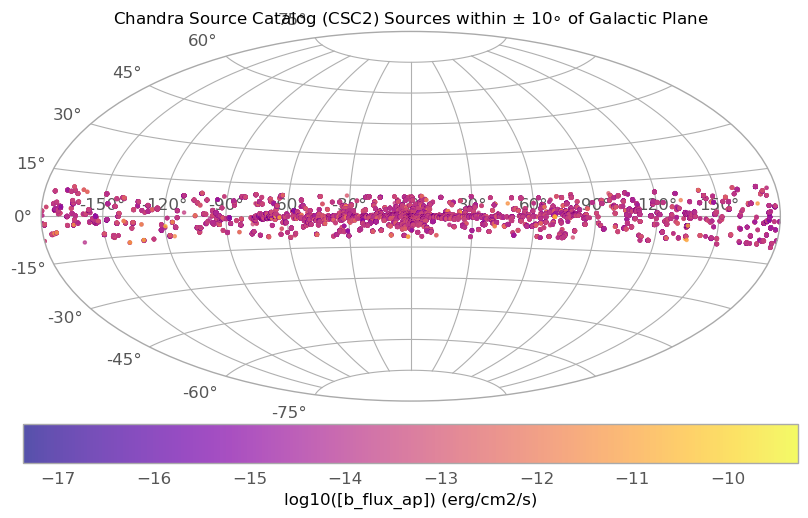

In [12]:
flux_log = np.log10(filtered_flux)

l_rad = filtered_coords.l.wrap_at(180*u.deg).radian
b_rad = filtered_coords.b.radian

plt.figure(figsize=(10, 6))
ax = plt.subplot(111, projection='aitoff')

sc = ax.scatter(l_rad, b_rad, c=flux_log, cmap='plasma', s=5, alpha=0.7)
cb = plt.colorbar(sc, orientation='horizontal', pad=0.05)
cb.set_label("log10([b_flux_ap]) (erg/cm2/s)",fontsize=12)

ax.grid(True)
plt.title("Chandra Source Catalog (CSC2) Sources within $\pm$ 10$\circ$ of Galactic Plane",fontsize=12)
plt.show()

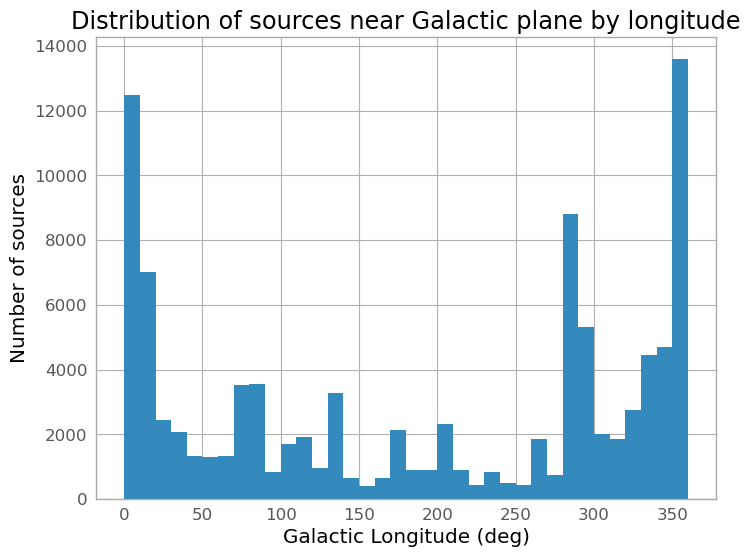

In [13]:
import matplotlib.pyplot as plt

l_deg = filtered_coords.l.deg

plt.hist(l_deg, bins=36, range=(0, 360))
plt.xlabel('Galactic Longitude (deg)')
plt.ylabel('Number of sources')
plt.title('Distribution of sources near Galactic plane by longitude')
plt.show()

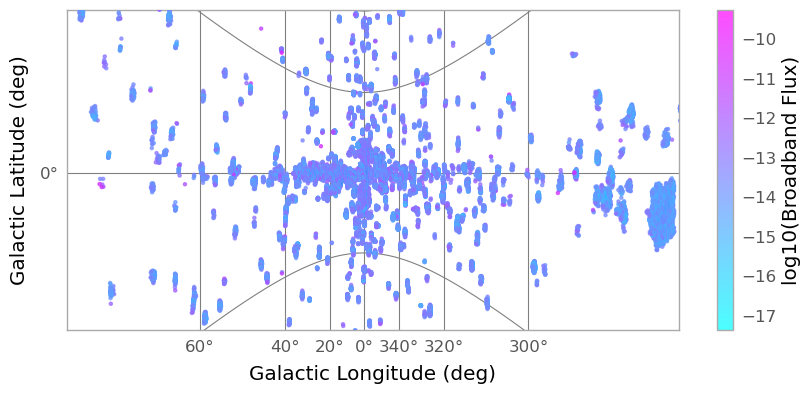

In [14]:
from astropy.wcs import WCS

# 1. Build a WCS header manually for Galactic coordinates
wcs = WCS(naxis=2)
wcs.wcs.ctype = ['GLON-TAN', 'GLAT-TAN']  # Galactic longitude/latitude
wcs.wcs.crval = [0, 0]  # Center of the plot in l and b
wcs.wcs.crpix = [900, 50]  # Reference pixel
wcs.wcs.cdelt = [-0.2, 0.2]  # Degrees per pixel
wcs.wcs.cunit = ['deg', 'deg']

# 2. Prepare your data (Galactic longitudes/latitudes in degrees)
l_deg = filtered_coords.l.wrap_at(180 * u.deg).deg
b_deg = filtered_coords.b.deg
flux_log = np.log10(filtered_flux + 1e-20)

# 3. Convert world coords (deg) to pixel coords
x_pix, y_pix = wcs.wcs_world2pix(l_deg, b_deg, 0)

# 4. Plot
fig = plt.figure(figsize=(9, 4))
ax = fig.add_subplot(111, projection=wcs)

sc = ax.scatter(x_pix, y_pix, c=flux_log, cmap='cool', s=5, alpha=0.7)

cb = plt.colorbar(sc, orientation='vertical', pad=0.05)
cb.set_label('log10(Broadband Flux)')

# 5. Set axis limits in pixel coords to match lon/lat range
ax.set_xlim(0, 1850)  # 360 deg / 0.2 deg per pixel = 1800 pixels
ax.set_ylim(0, 100)   # 20 deg / 0.2 deg per pixel = 100 pixels

# 6. Axis labels, ticks, grid (in world coordinates)
ax.coords.grid(True, color='grey', ls='-')
ax.coords[0].set_axislabel('Galactic Longitude (deg)')
ax.coords[1].set_axislabel('Galactic Latitude (deg)')
ax.coords[0].set_ticks(spacing=20 * u.deg)
ax.coords[1].set_ticks(spacing=5 * u.deg)

plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.15)
plt.show()

# Now let's read in the latest Fermi catalog to cross-match with the Galactic plane CSC sample and plot some of their properties

In [17]:
# Direct FSSC URL for 4FGL-DR4 catalog FITS file
fermi_url = "https://fermi.gsfc.nasa.gov/ssc/data/access/lat/14yr_catalog/gll_psc_v35.fit"
fermi_fname = "gll_psc_v35.fit"

# Download with curl (no new packages)
if not os.path.exists(fermi_fname):
    print("Downloading 4FGL-DR4 catalog from FSSC...")
    os.system(f"curl -O {fermi_url}")
    print("Download complete.")

# Load the FITS catalog
fermi_table = Table.read(fermi_fname)
print(f"Loaded {len(fermi_table)} Fermi sources.")

Loaded 7195 Fermi sources.


In [18]:
#fermi_table.colnames

In [19]:
csc = Table()
csc['csc_name'] = filtered_names
csc['csc_l'] = filtered_coords.l
csc['csc_b'] = filtered_coords.b
csc['b_flux_ap'] = filtered_flux

In [20]:
csc_coords = SkyCoord(l=csc['csc_l'], b=csc['csc_b'], unit='deg', frame='galactic')
fermi_coords = SkyCoord(l=fermi_table['GLON'], b=fermi_table['GLAT'], unit='deg', frame='galactic')

idx_fermi, idx_csc, sep2d, _ = csc_coords.search_around_sky(fermi_coords, 0.1 * u.deg)
#idx_fermi, idx_csc, sep2d, _ = fermi_coords.search_around_sky(csc_coords, 0.1 * u.deg)


In [21]:
print(idx_csc)
print(idx_fermi)
print(sep2d.deg)

[    30     33     38 ... 100817 100818 100819]
[  11   11   11 ... 7175 7175 7175]
[0.0975211  0.09069425 0.07884114 ... 0.08540754 0.09512734 0.08858047]


In [22]:
print(csc[30]['csc_name'])
print(fermi_table[11]['Source_Name'])
print(sep2d[0].deg)

2CXO J000112.0+672314
4FGL J0002.1+6721c
0.09752110120189145


In [23]:
print(csc[33]['csc_name'])
print(fermi_table[11]['Source_Name'])
print(sep2d[1].deg)

2CXO J000113.6+672107
4FGL J0002.1+6721c
0.09069425271774767


In [24]:
matched = Table()
matched['csc_name'] = csc['csc_name'][idx_csc]
matched['csc_l'] = csc['csc_l'][idx_csc]
matched['csc_b'] = csc['csc_b'][idx_csc]
matched['csc_flux'] = csc['b_flux_ap'][idx_csc]
matched['fermi_name'] = fermi_table['Source_Name'][idx_fermi]
matched['fermi_l'] = fermi_table['GLON'][idx_fermi]
matched['fermi_b'] = fermi_table['GLAT'][idx_fermi]
matched['fermi_r95'] = fermi_table['Conf_95_SemiMajor'][idx_fermi]
matched['fermi_flux'] = fermi_table['Energy_Flux100'][idx_fermi]
matched['fermi_class'] = fermi_table['CLASS1'][idx_fermi]
matched['sep_degree'] = sep2d.deg

print(f"Found {len(matched)} matches within 0.1°")
print(matched)

Found 19771 matches within 0.1°
       csc_name             csc_l        ... fermi_class      sep_degree    
                             deg         ...                                
--------------------- ------------------ ... ----------- -------------------
2CXO J000112.0+672314 118.11764827249455 ...       unk   0.09752110120189145
2CXO J000113.6+672107 118.11324333817218 ...       unk   0.09069425271774767
2CXO J000126.4+672339 118.14173989990837 ...       unk    0.0788411388603787
2CXO J000126.8+671848 118.12657916872396 ...       unk    0.0823245179517346
2CXO J000127.1+672353 118.14358886013505 ...       unk   0.07963004963143634
2CXO J000127.6+672220 118.13929934323465 ...       unk   0.06953347496188846
                  ...                ... ...         ...                 ...
2CXO J235836.2+623009 116.87599917133674 ...       spp    0.0881511101853717
2CXO J235831.6+623411 116.88096458316504 ...       spp   0.08252049833694755
2CXO J235833.3+622859 116.86655792082527 ...

/Users/jeagle/miniforge3/envs/fermi/lib/python3.9/site-packages/numpy/lib/function_base.py:3639: RuntimeWarning: invalid value encountered in divide
  return sin(y)/y


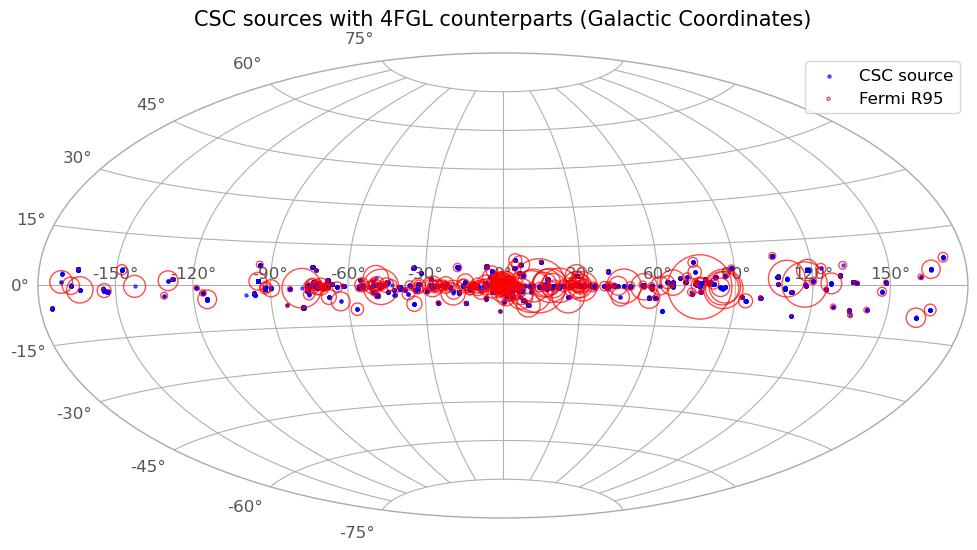

In [25]:
# Unique CSC and Fermi source rows
from astropy.table import unique, vstack
unique_csc = unique(matched, keys='csc_name')
unique_fermi = unique(matched, keys='fermi_name')

# CSC SkyCoords
csc_coords = SkyCoord(l=unique_csc['csc_l'], b=unique_csc['csc_b'], unit='deg', frame='galactic')
csc_lons = csc_coords.l.wrap_at(180 * u.deg).radian
csc_lats = csc_coords.b.radian

# Fermi SkyCoords
fermi_coords = SkyCoord(l=unique_fermi['fermi_l'], b=unique_fermi['fermi_b'], unit='deg', frame='galactic')
fermi_lons = fermi_coords.l.wrap_at(180 * u.deg).radian
fermi_lats = fermi_coords.b.radian

# Fermi R95 sizes
marker_scale = 100
fermi_r95_deg = unique_fermi['fermi_r95']
fermi_sizes = (fermi_r95_deg * marker_scale)**2

# Plot
plt.figure(figsize=(12, 6))
ax = plt.subplot(111, projection='aitoff')
ax.grid(True)

# Plot CSC points
ax.scatter(csc_lons, csc_lats, s=5, color='blue', alpha=0.6, label='CSC source')

# Plot Fermi 95% containment circles
ax.scatter(fermi_lons, fermi_lats, s=fermi_sizes, edgecolor='red', facecolor='none', alpha=0.7)
ax.scatter(0, 0, s=5, edgecolor='red', facecolor='none', alpha=0.7, label='Fermi R95')

ax.set_title("CSC sources with 4FGL counterparts (Galactic Coordinates)", pad=20, fontsize=15)
ax.legend(loc='best')

plt.subplots_adjust(bottom=0.1, top=0.95)
plt.show()

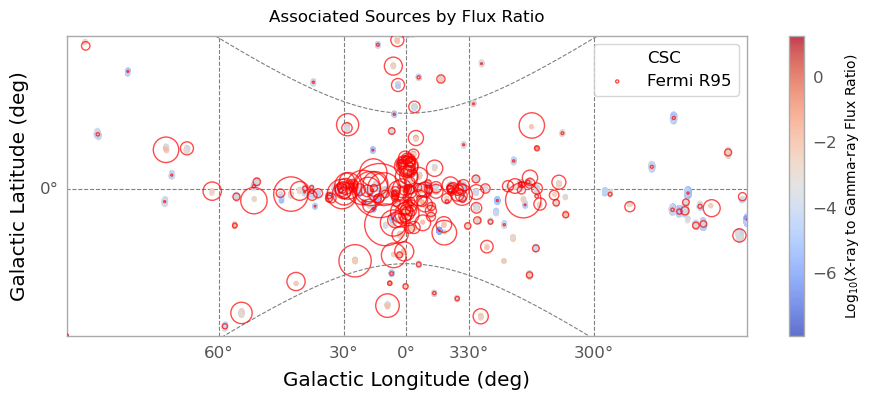

In [26]:
# Log flux ratio
flux_ratio = np.log10(matched['csc_flux'] / matched['fermi_flux'])

# 1. Build a WCS header manually for Galactic coordinates
wcs = WCS(naxis=2)
wcs.wcs.ctype = ['GLON-TAN', 'GLAT-TAN']  # Galactic longitude/latitude
wcs.wcs.crval = [0, 0]  # Center of the plot in l and b
wcs.wcs.crpix = [900, 50]  # Reference pixel
wcs.wcs.cdelt = [-0.2, 0.2]  # Degrees per pixel
wcs.wcs.cunit = ['deg', 'deg']

# CSC SkyCoords
csc_coords = SkyCoord(l=matched['csc_l'], b=matched['csc_b'], unit='deg', frame='galactic')
csc_lons = csc_coords.l.wrap_at(180 * u.deg).deg
csc_lats = csc_coords.b.deg

# Fermi SkyCoords
fermi_coords = SkyCoord(l=unique_fermi['fermi_l'], b=unique_fermi['fermi_b'], unit='deg', frame='galactic')
fermi_lons = fermi_coords.l.wrap_at(180 * u.deg).deg
fermi_lats = fermi_coords.b.deg

# Fermi R95 sizes
marker_scale = 100
fermi_r95_deg = unique_fermi['fermi_r95']
fermi_sizes = (fermi_r95_deg * marker_scale)**2

# Step 3: Convert to pixel coords
csc_x_pix, csc_y_pix = wcs.wcs_world2pix(csc_coords.l.wrap_at(180 * u.deg).deg, csc_coords.b.deg, 0)
fermi_x_pix, fermi_y_pix = wcs.wcs_world2pix(fermi_coords.l.wrap_at(180 * u.deg).deg, fermi_coords.b.deg, 0)

# Step 4: Plot
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111, projection=wcs)

# CSC points, colored by flux ratio
sc = ax.scatter(csc_x_pix, csc_y_pix, c=flux_ratio, cmap='coolwarm', s=8, alpha=0.8, label='CSC')

# Fermi R95 circles
ax.scatter(fermi_x_pix, fermi_y_pix, s=fermi_sizes, edgecolor='red', facecolor='none', alpha=0.7)
ax.scatter(0, 0, s=5, edgecolor='red', facecolor='none', alpha=0.7, label='Fermi R95')

# Colorbar
cb = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.05)
cb.set_label(r'Log$_{10}$(X-ray to Gamma-ray Flux Ratio)',fontsize=10)

# Axis limits
ax.set_xlim(0, 1800)
ax.set_ylim(0, 100)

# Axes formatting
ax.coords.grid(True, color='gray', ls='--')
ax.coords[0].set_axislabel('Galactic Longitude (deg)')
ax.coords[1].set_axislabel('Galactic Latitude (deg)')
ax.coords[0].set_ticks(spacing=30 * u.deg)
ax.coords[1].set_ticks(spacing=5 * u.deg)

ax.set_title("Associated Sources by Flux Ratio", pad=10,fontsize=12)
ax.legend(loc='upper right')

plt.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9)
plt.show()

In [32]:
# Step 1: Unique Fermi sources
unique_pairs = unique(matched, keys=['csc_name', 'fermi_name'])
unique_fermi_names = list(set(unique_pairs['fermi_name']))

# Step 2: Prepare row containers
rows = []

for fname in unique_fermi_names:
    # Filter for this Fermi source
    mask = unique_pairs['fermi_name'] == fname
    group = unique_pairs[mask]

    # Use first row for Fermi info
    f_row = group[0]

    # Extract CSC info as Python lists
    csc_names = list(group['csc_name'])
    csc_fluxes = list(group['csc_flux'])
    csc_lons = list(group['csc_l'])
    csc_b_lats = list(group['csc_b'])

    n_matches = len(csc_names)

    # Append row
    rows.append((
        fname,
        f_row['fermi_l'],
        f_row['fermi_b'],
        f_row['fermi_flux'],
        f_row['fermi_r95'],
        n_matches,
        csc_names,
        csc_fluxes,
        csc_lons,
        csc_b_lats
    ))

# Step 3: Build final table
grouped_display_table = Table(rows=rows, names=[
    'fermi_name', 'fermi_l', 'fermi_b', 'fermi_flux', 'fermi_r95',
    'num_csc_matches', 'csc_names', 'csc_fluxes', 'csc_glons', 'csc_glats'
])

# Step 4: Preview
grouped_display_table.pprint(max_width=-1)

    fermi_name      fermi_l     fermi_b      fermi_flux       fermi_r95       num_csc_matches                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [33]:
export_table = grouped_display_table.copy()
export_table.sort(['fermi_l', 'fermi_b'])

# Convert all list-like columns to strings
for col in export_table.colnames:
    if isinstance(export_table[col][0], (list, tuple)):
        export_table[col] = [', '.join(str(x) for x in row) for row in export_table[col]]

# Write to CSV
export_table.write("grouped_csc_fermi_pairs.csv", format="csv", overwrite=True)

/Users/jeagle/miniforge3/envs/fermi/lib/python3.9/site-packages/numpy/lib/stride_tricks.py:538: UserWarning: Warning: converting a masked element to nan.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]


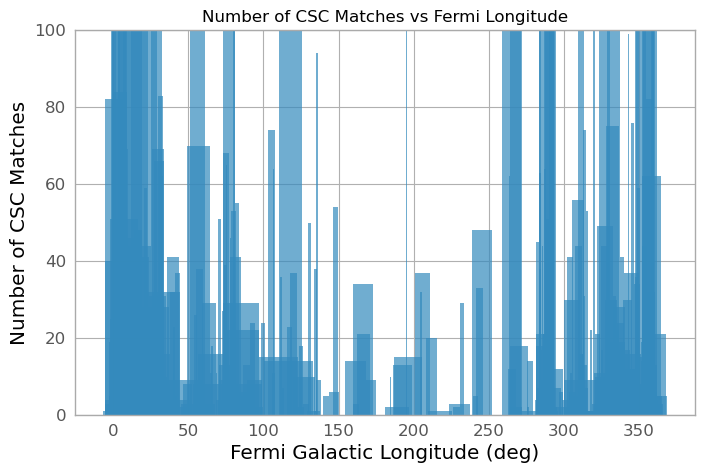

In [34]:
# Count CSC matches per Fermi source using a dict
fermi_counts = {}
for fname in matched['fermi_name']:
    fermi_counts[fname] = fermi_counts.get(fname, 0) + 1

fermi_lons = []
num_csc_matches = []

for fname, count in fermi_counts.items():
    # Find fermi longitude in unique_fermi
    idx = (unique_fermi['fermi_name'] == fname).nonzero()[0]
    if len(idx) == 0:
        continue
    lon = unique_fermi['fermi_l'][idx[0]]
    fermi_lons.append(lon)
    num_csc_matches.append(count)

plt.figure(figsize=(8,5))
plt.bar(fermi_lons, num_csc_matches, 100*unique_fermi['fermi_r95'], alpha=0.7,lw=2)
plt.xlabel('Fermi Galactic Longitude (deg)')
plt.ylabel('Number of CSC Matches')
plt.title('Number of CSC Matches vs Fermi Longitude', fontsize=12)
plt.ylim(0,100)
plt.grid(True)
plt.show()

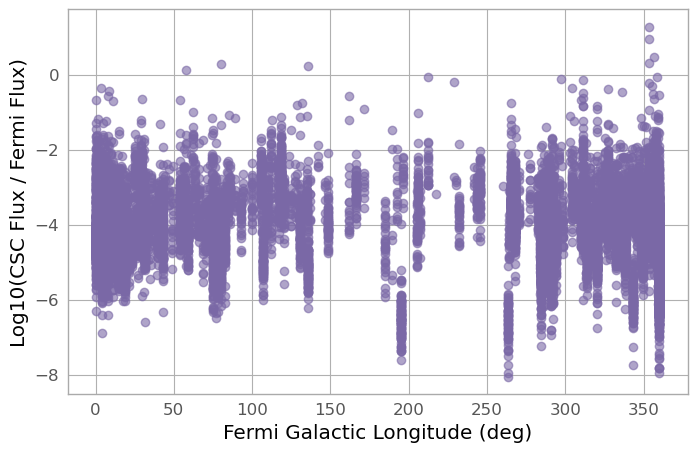

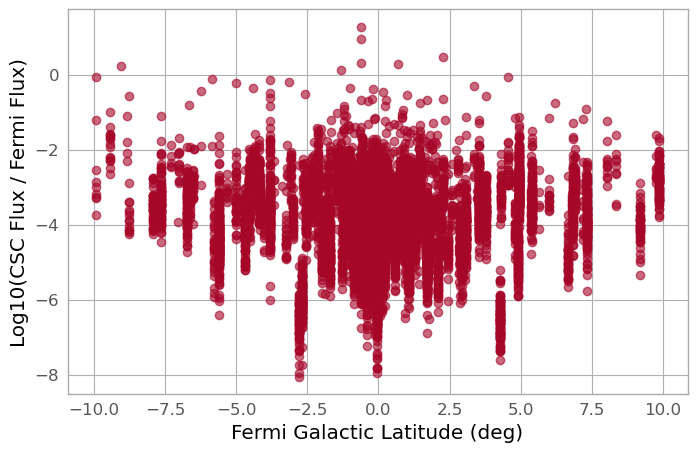

In [35]:
log_flux_ratio = np.log10(matched['csc_flux'] / matched['fermi_flux'])

plt.figure(figsize=(8,5))
plt.scatter(matched['fermi_l'], log_flux_ratio, alpha=0.6, color='C1')
plt.xlabel('Fermi Galactic Longitude (deg)')
plt.ylabel('Log10(CSC Flux / Fermi Flux)')
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.scatter(matched['fermi_b'], log_flux_ratio, alpha=0.6, color='C2')
plt.xlabel('Fermi Galactic Latitude (deg)')
plt.ylabel('Log10(CSC Flux / Fermi Flux)')
plt.grid(True)
plt.show()


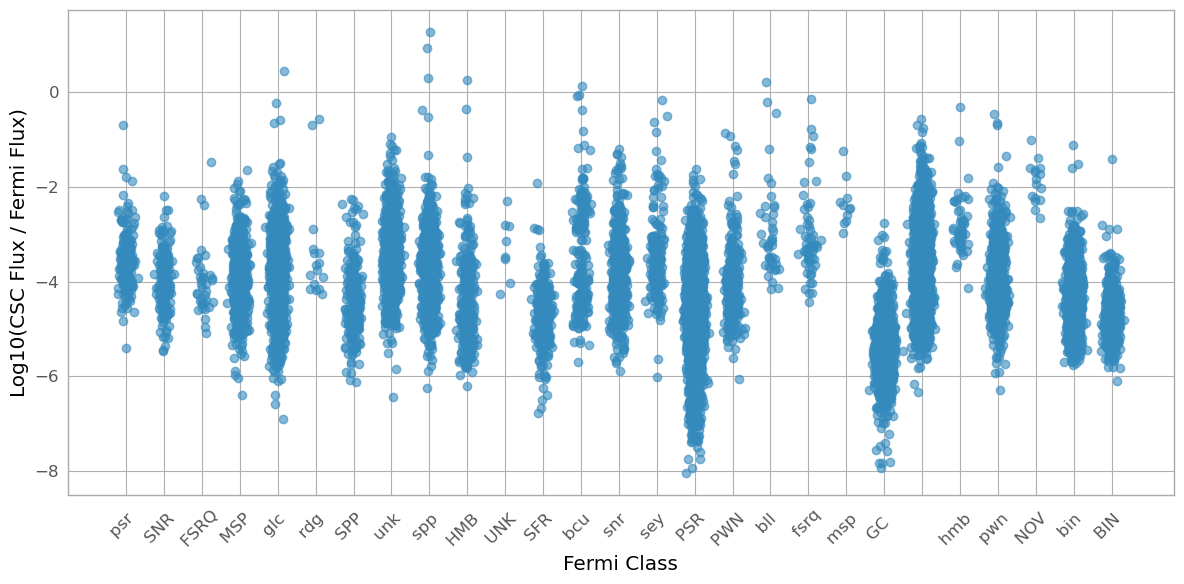

In [36]:
# Extract unique classes and map to numbers for plotting
classes = list(set(matched['fermi_class']))
class_to_num = {cls: i for i, cls in enumerate(classes)}

# Prepare x values with jitter
import numpy as np

x_vals = np.array([class_to_num[c] for c in matched['fermi_class']])
jitter = np.random.normal(0, 0.1, size=len(x_vals))
x_jittered = x_vals + jitter

plt.figure(figsize=(12,6))
plt.scatter(x_jittered, log_flux_ratio, alpha=0.6)
plt.xticks(range(len(classes)), classes, rotation=45)
plt.xlabel('Fermi Class')
plt.ylabel('Log10(CSC Flux / Fermi Flux)')
plt.grid(True)
plt.tight_layout()
plt.show()